In [1]:
%load_ext autoreload

In [2]:
cd ..

/home/mars/mount/src_aiai


In [3]:
%autoreload 2
%aimport src.visualisation

In [4]:
import pandas as pd

In [5]:
import pkg_resources

# __requires__= 'numpy>=1.16.5'
# pkg_resources.require('numpy>=1.16.5')
import numpy as np

# __requires__= 'scipy==1.6.3'
# pkg_resources.require('scipy==1.6.3')
# import scipy



In [6]:
import matplotlib.pyplot as plt


In [7]:
from src.data import load_M51
from src.sampling.uv_sampling import spider_sampling
from src.operators.measurement import NUFFT_op
# from src.solvers import PrimalDual_l1_constrained
from src.visualisation import compare
# from src.operators.dictionary import wavelet_basis

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [8]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

In [9]:
import tqdm

In [10]:
# data + operator

In [11]:
uv = spider_sampling() 
m_op = NUFFT_op(uv)

In [12]:
# ramp filter
w_ramp = np.linalg.norm(uv, axis=1)
w_ramp = w_ramp/w_ramp.max()


# 1 over amount of in shared grid cell
w_natural = np.ones(len(uv))

grid_cell = 2*np.pi /512 
binned = (uv[:,:]+np.pi+.5*grid_cell) // grid_cell
binned = [tuple(x) for x in binned]
cells = set(binned)
w_gridded = np.zeros(uv.shape[0])
for cell in list(cells):
    mask = np.all(np.array(cell) ==  binned, axis=1)
    w_gridded[mask] = np.sum(mask) #np.sum( (w_natural[mask])**2 ) /np.sum(mask)
# counts = [np.sum(x_c == cell) for cell in list(cells)]
w_grid = w_natural/w_gridded


# 1 over all within 1 grid cell points
dist = -1 * np.dot(uv, uv.T) -1 * np.dot(uv, uv.T).T + np.sum(uv**2, axis=1) + np.sum(uv**2, axis=1)[:,np.newaxis] # (x-y)'(x-y) = x'x + y'y - x'y -y'x
dist[dist < 0] = 0 # correct for numerical errors
gridsize = 2*np.pi/512
w_distance = 1/np.sum(dist**.5 < gridsize, axis=1) # all pixels within 1 gridcell distancex_f = m_op.adj_op(y_*w/w.max())

def sinc2(x):
    return np.prod(np.sinc(np.pi*x))**2

j=1
w = [ np.sum([ sinc2(uv[i] - uv[j]) for i in range(len(uv))] ) for j in tqdm.tqdm(range(len(uv)))]

w_ = 1/np.array(w)
w_sinc = w_/w_.max()

100%|███████████████████████████████████████████████████████████████| 4440/4440 [05:01<00:00, 14.75it/s]


In [13]:
x_true = np.load('./data/intermediate/BSDS/x_true_train_50dB.npy')

In [14]:
def dirty_image(x_true, m_op, weights):
    x_dirty = np.zeros_like(x_true)
    for i in tqdm.tqdm(range(len(x_true))):
        y0 = m_op.dir_op(x_true[i,:,:,0])
#         ISNR = 50 #dB
#         sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
#         noise = np.random.normal(0, sigma, y0.shape) + 1j * np.random.normal(0, sigma, y0.shape)
#         y = y0 + noise
        y = y0
        x_dirty[i,:,:,0] = m_op.adj_op(y*weights)
#         noise_val = np.sqrt(2)*sigma #np.std(m_op.adj((noise)))
    return x_dirty

In [15]:
x_dirty = dirty_image(x_true, m_op, 1)

  0%|                                                                           | 0/200 [00:00<?, ?it/s]<ipython-input-14-e56324303fad>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  x_dirty[i,:,:,0] = m_op.adj_op(y*weights)
100%|█████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.48it/s]


In [16]:
x_ramp = dirty_image(x_true, m_op, w_ramp)

  0%|                                                                           | 0/200 [00:00<?, ?it/s]<ipython-input-14-e56324303fad>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  x_dirty[i,:,:,0] = m_op.adj_op(y*weights)
100%|█████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 52.15it/s]


In [17]:
x_grid = dirty_image(x_true, m_op, w_grid)

  0%|                                                                           | 0/200 [00:00<?, ?it/s]<ipython-input-14-e56324303fad>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  x_dirty[i,:,:,0] = m_op.adj_op(y*weights)
100%|█████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.08it/s]


In [18]:
x_distance = dirty_image(x_true, m_op, w_distance)

  0%|                                                                           | 0/200 [00:00<?, ?it/s]<ipython-input-14-e56324303fad>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  x_dirty[i,:,:,0] = m_op.adj_op(y*weights)
100%|█████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.35it/s]


In [19]:
x_sinc = dirty_image(x_true, m_op, w_sinc)

  0%|                                                                           | 0/200 [00:00<?, ?it/s]<ipython-input-14-e56324303fad>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  x_dirty[i,:,:,0] = m_op.adj_op(y*weights)
100%|█████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.38it/s]


In [20]:
results = [
    ("dirty", "", x_true, x_dirty ),
    ("ramp", "", x_true, x_ramp ),
    ("grid", "", x_true, x_grid ),
    ("distance", "", x_true, x_distance ),
    ("sinc2", "", x_true, x_sinc ),
]

In [21]:
metrics = [
    ("PSNR", peak_signal_noise_ratio),
    ("SSIM", structural_similarity),
    ("MSE", mean_squared_error)
]

In [22]:
def compute_statistics(results, metrics):
    statistics = pd.DataFrame(columns=["PSNR", "SSIM", "MSE", "method", "set"])#{}
    statistics["PSNR"] = 0
        # statistics[metric] = pd.DataFrame()
    for name, sets, x, y in tqdm.tqdm(results):
        df = pd.DataFrame()
        for metric, f in metrics:
            df[metric] = [f(x[i,:,:,0],y[i,:,:,0]) for i in range(len(x))]
        df['Method'] = name
        df['Set'] = sets
        if statistics.empty:
            statistics = df
        else:
            statistics = statistics.append(df, ignore_index=False)
            
    with pd.option_context('mode.use_inf_as_na', True):
        statistics.dropna(inplace=True)
    return statistics

In [23]:
def print_statistics(statistics, results, metrics):
    print(f"|{'Name':20}|", end="")
    for metric, f in metrics:
        print(f"{metric:20}|", end="")
    print()
    for name, set, x, y in results:
        print(f"|{name+'_'+set:20}|", end="")
        for metric, f in metrics:
            print(f"{np.mean(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):8.3f} \pm {np.std(statistics[metric][(statistics.Method == name) * (statistics.Set == set)]):7.3f}|", end="")
        print()

In [24]:
stats = compute_statistics(results, metrics)

100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


In [25]:
print_statistics(stats, results, metrics)

|Name                |PSNR                |SSIM                |MSE                 |
|dirty_              |   4.259 \pm   1.994|   0.152 \pm   0.058|   0.415 \pm   0.185|
|ramp_               |   6.564 \pm   1.877|   0.007 \pm   0.019|   0.241 \pm   0.099|
|grid_               |   7.541 \pm   1.937|   0.094 \pm   0.058|   0.194 \pm   0.083|
|distance_           |   6.868 \pm   1.897|   0.021 \pm   0.038|   0.225 \pm   0.094|
|sinc2_              |   6.404 \pm   1.866|   0.006 \pm   0.007|   0.250 \pm   0.102|


/home/mars/Documents/src_aiai/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [26]:
x_true = load_M51()
x_true /= x_true.max()
# x_true = np.ones_like(x_true)
y0 = m_op.dir_op(x_true)
ISNR = 50 #dB
sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
noise = np.random.normal(0, sigma, y0.shape) + 1j * np.random.normal(0, sigma, y0.shape)
y = y0 + noise

x_dirty = m_op.adj_op(y)
noise_val = np.sqrt(2)*sigma #np.std(m_op.adj((noise)))

w_r = np.linalg.norm(uv, axis=1)
w_r = w_r/w_r.max()
# x_f = m_op.adj_op(y*w/w.max())



In [10]:
w_natural = np.ones(len(uv))


grid_cell = 2*np.pi /512 
binned = (uv[:,:]+np.pi+.5*grid_cell) // grid_cell
binned = [tuple(x) for x in binned]
cells = set(binned)
w_gridded = np.zeros(uv.shape[0])
for cell in list(cells):
    mask = np.all(np.array(cell) ==  binned, axis=1)
    w_gridded[mask] = np.sum(mask) #np.sum( (w_natural[mask])**2 ) /np.sum(mask)
# counts = [np.sum(x_c == cell) for cell in list(cells)]
# w_uniform = 

In [72]:
dist = -1 * np.dot(uv, uv.T) -1 * np.dot(uv, uv.T).T + np.sum(uv**2, axis=1) + np.sum(uv**2, axis=1)[:,np.newaxis] # (x-y)'(x-y) = x'x + y'y - x'y -y'x
dist[dist < 0] = 0 # correct for numerical errors
gridsize = 2*np.pi/512
w = 1/np.sum(dist**.5 < gridsize, axis=1) # all pixels within 1 gridcell distancex_f = m_op.adj_op(y_*w/w.max())

In [73]:
# w_gridded = count/count.max()
w_uniform = w_natural/w_gridded

In [18]:
import tqdm 

In [52]:
def sinc2(x):
    return np.prod(np.sinc(np.pi*x))**2

j=1
w = [ np.sum([ sinc2(uv[i] - uv[j]) for i in range(len(uv))] ) for j in tqdm.tqdm(range(len(uv)))]






  0%|          | 0/4440 [00:00<?, ?it/s]




  0%|          | 2/4440 [00:00<05:19, 13.88it/s]




  0%|          | 4/4440 [00:00<05:20, 13.86it/s]




  0%|          | 6/4440 [00:00<05:18, 13.91it/s]




  0%|          | 8/4440 [00:00<05:18, 13.93it/s]




  0%|          | 10/4440 [00:00<05:17, 13.94it/s]




  0%|          | 12/4440 [00:00<05:17, 13.94it/s]




  0%|          | 14/4440 [00:01<05:17, 13.92it/s]




  0%|          | 16/4440 [00:01<05:17, 13.93it/s]




  0%|          | 18/4440 [00:01<05:17, 13.93it/s]




  0%|          | 20/4440 [00:01<05:17, 13.93it/s]




  0%|          | 22/4440 [00:01<05:16, 13.94it/s]




  1%|          | 24/4440 [00:01<05:16, 13.94it/s]




  1%|          | 26/4440 [00:01<05:16, 13.96it/s]




  1%|          | 28/4440 [00:02<05:16, 13.94it/s]




  1%|          | 30/4440 [00:02<05:16, 13.91it/s]




  1%|          | 32/4440 [00:02<05:17, 13.89it/s]




  1%|          | 34/4440 [00:02<05:17, 13.90it/s]




  1%|          | 36/4440 [00:02<05:1

/lustre/home/ucapmm6/src_aiai/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


nan

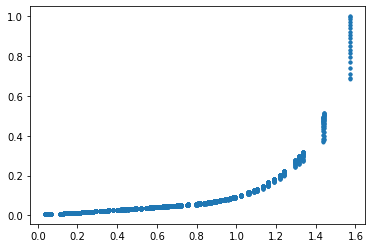

In [71]:
plt.plot(np.linalg.norm(uv, axis=1), w_, '.')

In [54]:
w_ = 1/np.array(w)
w_ /= w_.max()

In [13]:
x_true = np.ones_like(x_true)
y = np.ones_like(y) #m_op.dir_op(x_true)

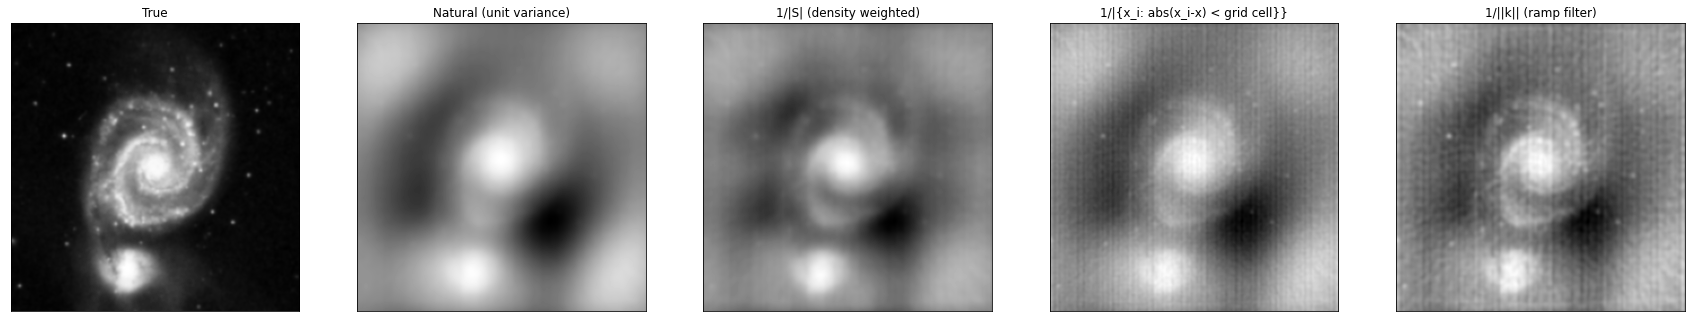

In [74]:
compare([x_true.real, m_op.adj_op(y*w_natural).real, m_op.adj_op(y*w_uniform).real,  m_op.adj_op(y*w_).real,  m_op.adj_op(y*w_r).real],
        titles=["True", "Natural (unit variance)", "1/|S| (density weighted)", "1/|{x_i: abs(x_i-x) < grid cell}}", "1/||k|| (ramp filter)"])

In [75]:
ws = [m_op.adj_op(y*w_natural).real, m_op.adj_op(y*w_uniform).real,  m_op.adj_op(y*w_).real,  m_op.adj_op(y*w_r).real]

In [57]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

In [76]:
for i in ws:
    print(structural_similarity(x_true, i), peak_signal_noise_ratio(x_true, i), mean_squared_error(x_true,i))

0.07464947819930062 6.323799051008386 0.23314177301225827
0.09046587080705029 8.811053073334554 0.13149059563255605
0.005879369975923182 8.354204408272194 0.14607623245609602
0.012096904594457813 8.430154767839328 0.14354382782852326


In [70]:
np.prod(np.sinc(uv[0]))

0.9923452168022412